* 仅仅使用 CompanyName 来做！总共348个样本!

In [39]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import gc
import gzip
import os
import warnings
import random
import graphviz
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from bayes_opt import BayesianOptimization
from graphviz import Digraph

%matplotlib inline

In [40]:
df = pd.read_csv("./merge_result.csv")
df = df.loc[df['is_defunct'].notnull()]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19591 entries, 0 to 21540
Columns: 176 entries, companyName to entertainment_rp
dtypes: float64(167), int64(1), object(8)
memory usage: 26.5+ MB
None


In [41]:
df = df.sort_values(['companyName', 'DOW'], ascending=False).groupby('companyName', as_index=False).first()
display(df)

,companyName,DOW,cabin_nunique,LR_min,LR_max,LR_mean,LR_std,LR_median,SC_min,SC_max,...,max_accident_date,max_fatalities,total_fatalities,accident_cnt,review_count_rp,rating_rp,cabin_crew_rp,meal_rp,comfort_rp,entertainment_rp
0,ANA (All Nippon Airways),2019-07,3.0,1.0,5.0,4.285714,1.053850,5.0,1.0,5.0,...,2002-06-26,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,ASKY Airlines,2019-07,1.0,2.0,5.0,3.666667,1.527525,4.0,2.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ATA Airlines (Iran),2019-05,1.0,1.0,1.0,1.000000,1.707825,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,6.0,7.0,7.8,-99.0,6.6,5.9
3,Air Canada Rouge,2019-08,2.0,1.0,5.0,2.671329,1.351974,3.0,1.0,5.0,...,NaN,NaN,NaN,NaN,25.0,6.6,7.8,6.3,6.2,6.3
4,Air Caraibes,2019-07,1.0,3.0,4.0,3.500000,0.707107,3.5,3.0,5.0,...,NaN,NaN,NaN,NaN,137.0,7.3,7.9,7.3,7.3,6.2
5,Air China,2019-08,3.0,1.0,5.0,3.288136,1.246386,3.0,1.0,5.0,...,2002-04-15,129.0,129.0,1.0,163.0,7.0,7.2,6.8,7.6,6.4
6,Air Corsica,2019-07,1.0,1.0,5.0,3.500000,1.732051,4.0,1.0,5.0,...,NaN,NaN,NaN,NaN,73.0,6.2,6.9,5.5,7.1,5.1
7,Air Costa (no longer operating),2017-11,1.0,5.0,5.0,5.000000,NaN,5.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Air Dolomiti,2019-07,1.0,1.0,4.0,3.000000,1.414214,3.5,1.0,4.0,...,NaN,NaN,NaN,NaN,14.0,7.6,8.5,7.4,7.8,6.7
9,Air Europa,2019-08,2.0,1.0,5.0,2.916667,1.501207,3.0,1.0,5.0,...,NaN,NaN,NaN,NaN,93.0,6.5,7.0,-99.0,7.4,6.0


In [42]:
test_company = ['Primera Air [no longer operating]', 'Monarch [no longer operating]', 'WOW air [no longer operating]', 'Air France', 'Virgin Australia', 'Viva Aerobus', 'Central Mountain Air', 'Juneyao Airlines', 'Ural Airlines', 'Corendon Airlines', 'Jeju Air', 'Royal Air Maroc', 'Vanilla Air', 'Kuwait Airways', 'Philippine Airlines (PAL)', 'TAME Vuela Ecuador', 'Pobeda', 'SmartWings', 'Thomas Cook Airlines Scandinavia', 'Ukraine International Airlines', 'Cayman Airways', 'Croatia Airlines', 'Kulula', 'Beijing Capital Airlines', 'China Eastern Airlines', 'QAZAQ AIR', 'Jetstar Japan',  'Silver Airways', 'Tajik Air', 'Boliviana de Aviacion', 'Mauritania Airlines', 'Myanmar National Airlines', 'AirAsia - Philippines AirAsia', 'Interjet', 'Myanmar Airways International', 'Wamos Air', 'Andes Lineas Aereas', 'Air Panama', 'TUIfly (Germany)', 'Royal Jordanian', 'Lufthansa', 'Norwegian', 'Virgin Atlantic Airways', 'Mann Yadanarpon Airlines', 'Kan Airlines', 'Sudan Airways', 'Viva Air (Colombia)', 'Biman Bangladesh Airlines', 'China Southern Airlines', 'Flynas', 'SriLankan Airlines', 'Sun Country Airlines', 'Nordica', 'AnadoluJet', 'Thai Lion Air', 'Flyadeal', 'Jin Air', 'tigerair australia', 'Air Madagascar', 'Southwest Airlines', 'Nouvel Air Tunise', 'TAROM', 'Wings Air', 'British Airways']
test = df[df['companyName'].isin(test_company)]
train = df[~df['companyName'].isin(test_company)]
y_train = train['is_defunct']
X_train = train.drop(columns=['is_defunct'])
y_test = test['is_defunct']
X_test = test.drop(columns=['is_defunct'])

features = list(X_train.columns)
del_cols = ['companyName', 'DOW', 'country_code', 'busn_name', 'cust_id_concatenate', 'airline_tagging', 'country', 'max_accident_date']
for col in del_cols:
    features.remove(col)

# 参数

In [43]:
param = { #修改过的
    "boosting": "gbdt",
    'objective':'binary',
    'metric': ('auc', 'binary_logloss'),
#     'metric': 'binary_logloss',
    'num_leaves': 10, 
    'min_data_in_leaf': 10, #120
    'max_depth': 5,                        
    "feature_fraction": 1,
    "bagging_freq": 1,  #int(bagging_freq),   #1
    "bagging_fraction": 1 ,
    "bagging_seed": 11,
    "verbosity": -1,        
}

In [44]:
# folds = KFold(n_splits=5, shuffle=True, random_state=15)
# oof = np.zeros(len(X_train))
# predictions = np.zeros(len(X_test))
# feature_importance_df = pd.DataFrame()
# evals_result = {}  #记录训练结果所用

# for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
#     print("fold n°{}".format(fold_))
#     trn_data = lgb.Dataset(X_train.iloc[trn_idx][features],
#                            label=y_train.iloc[trn_idx])
#     val_data = lgb.Dataset(X_train.iloc[val_idx][features],
#                            label=y_train.iloc[val_idx])

#     num_round = 1
#     clf = lgb.train(param,
#                     trn_data,
#                     num_round,
#                     valid_sets = [trn_data, val_data],
#                     evals_result=evals_result,   #非常重要的参数,一定要明确设置
#                     verbose_eval=10,
#                     early_stopping_rounds=100
#     )
    
#     oof[val_idx] = clf.predict(X_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["feature"] = features
#     fold_importance_df["importance"] = clf.feature_importance()
#     fold_importance_df["fold"] = fold_ + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
#     predictions += clf.predict(X_test[features], num_iteration=clf.best_iteration) / folds.n_splits

fold n°0
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1]	training's auc: 0.970646	training's binary_logloss: 0.107398	valid_1's auc: 0.544811	valid_1's binary_logloss: 0.286482
fold n°1
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1]	training's auc: 0.97107	training's binary_logloss: 0.131459	valid_1's auc: 0.436364	valid_1's binary_logloss: 0.157651
fold n°2
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1]	training's auc: 0.964926	training's binary_logloss: 0.138046	valid_1's auc: 0.713636	valid_1's binary_logloss: 0.13761
fold n°3
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1]	training's auc: 0.972222	training's binary_logloss: 0.132953	valid_1's auc: 0.444444	valid_1's binary_logloss: 0.161315
fold n°4
Training until va

In [72]:
from sklearn import tree

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
clf = tree.DecisionTreeClassifier(max_depth=6, max_features=9, random_state=4)
clf.fit(X_train[features], y_train)
clf.predict_proba(X_test[features])

array([[0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.625     , 0.375     ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.66666667, 0.33333333],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.625     , 0.375     ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.

In [73]:
tmp = clf.predict_proba(X_test[features])
for i in range(64):
    print("{} - {}".format(X_test.reset_index().iloc[i,1], tmp[i]))

Air France - [0. 1.]
Air Madagascar - [1. 0.]
Air Panama - [1. 0.]
AirAsia - Philippines AirAsia - [1. 0.]
AnadoluJet - [1. 0.]
Andes Lineas Aereas - [1. 0.]
Beijing Capital Airlines - [1. 0.]
Biman Bangladesh Airlines - [1. 0.]
Boliviana de Aviacion - [1. 0.]
British Airways - [0.625 0.375]
Cayman Airways - [1. 0.]
Central Mountain Air - [1. 0.]
China Eastern Airlines - [1. 0.]
China Southern Airlines - [1. 0.]
Corendon Airlines - [1. 0.]
Croatia Airlines - [1. 0.]
Flyadeal - [1. 0.]
Flynas - [1. 0.]
Interjet - [1. 0.]
Jeju Air - [1. 0.]
Jetstar Japan - [1. 0.]
Jin Air - [0.66666667 0.33333333]
Juneyao Airlines - [1. 0.]
Kan Airlines - [1. 0.]
Kulula - [1. 0.]
Kuwait Airways - [1. 0.]
Lufthansa - [0.625 0.375]
Mann Yadanarpon Airlines - [1. 0.]
Mauritania Airlines - [1. 0.]
Monarch [no longer operating] - [1. 0.]
Myanmar Airways International - [1. 0.]
Myanmar National Airlines - [1. 0.]
Nordica - [1. 0.]
Norwegian - [0.625 0.375]
Nouvel Air Tunise - [1. 0.]
Philippine Airlines (PAL) 

[Text(201.27857142857144, 201.90857142857143, 'X[158] <= 175.0\nentropy = 0.075\nsamples = 283\nvalue = [272, 11]'),
 Text(131.52857142857144, 170.84571428571428, 'X[126] <= 2.905\nentropy = 0.057\nsamples = 272\nvalue = [264, 8]'),
 Text(115.58571428571429, 139.78285714285715, 'entropy = 0.0\nsamples = 146\nvalue = [146, 0]'),
 Text(147.47142857142856, 139.78285714285715, 'X[134] <= 0.095\nentropy = 0.119\nsamples = 126\nvalue = [118, 8]'),
 Text(103.62857142857143, 108.72, 'X[134] <= 0.084\nentropy = 0.241\nsamples = 50\nvalue = [43, 7]'),
 Text(63.77142857142857, 77.65714285714284, 'X[101] <= 4.5\nentropy = 0.159\nsamples = 46\nvalue = [42, 4]'),
 Text(31.885714285714286, 46.59428571428572, 'X[48] <= -0.038\nentropy = 0.059\nsamples = 33\nvalue = [32, 1]'),
 Text(15.942857142857143, 15.531428571428563, 'entropy = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(47.82857142857143, 15.531428571428563, 'entropy = 0.0\nsamples = 30\nvalue = [30, 0]'),
 Text(95.65714285714286, 46.594285714285

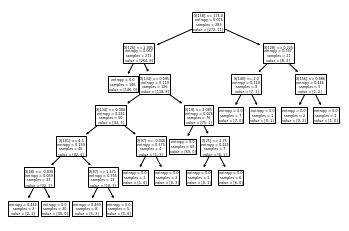

In [74]:
tree.plot_tree(clf.fit(X_train[features], y_train)) 

In [45]:
# ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def draw_ROC_curve(y_test,y_predict,savepath=None):
    '''
    画ROC曲线
    '''
    false_positive_rate,true_positive_rate,thresholds=roc_curve(y_test, y_predict)
    print(thresholds)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    if savepath:
        plt.savefig(savepath)
    plt.close(0)

[1.15831673 0.15831673 0.12140511 0.11589226 0.10284597 0.05931375
 0.0538955  0.04687303 0.04629615 0.03985178 0.0386727  0.03602611
 0.03586744 0.0280216  0.0280216 ]


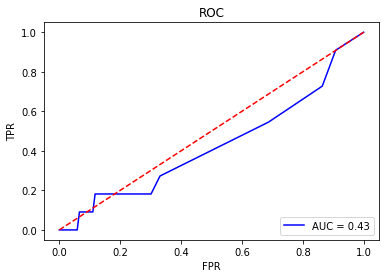

In [46]:
draw_ROC_curve(y_train, oof)

[1.092526   0.092526   0.09142159 0.08272656 0.06913285 0.06559838
 0.0433506  0.04187014 0.0400225  0.03796735 0.03728883 0.03721376
 0.03721262 0.03656286 0.03515861 0.03515861]


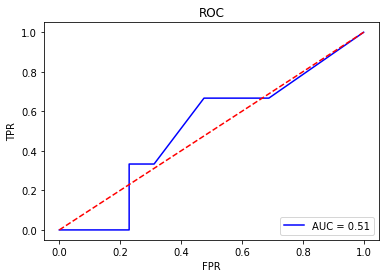

In [47]:
draw_ROC_curve(y_test, predictions)

In [48]:
new_test = pd.concat([test['companyName'].reset_index(), pd.Series(predictions, name='pred')], axis=1)
new_test_company = ['Primera Air [no longer operating]', 'Monarch [no longer operating]', 'WOW air [no longer operating]']
new_test = new_test[new_test['companyName'].isin(new_test_company)]

display(new_test.groupby('companyName')['pred'].agg(['mean', 'min', 'max']))

,mean,min,max
companyName,,,
Monarch [no longer operating],0.035159,0.035159,0.035159
Primera Air [no longer operating],0.041870,0.041870,0.041870
WOW air [no longer operating],0.037289,0.037289,0.037289


In [49]:
new_test = pd.concat([test['companyName'].reset_index(), pd.Series(predictions, name='pred')], axis=1)

display(new_test.groupby('companyName')['pred'].agg(['mean', 'min', 'max']).sort_values('mean', ascending=False))

,mean,min,max
companyName,,,
Kulula,0.092526,0.092526,0.092526
Air France,0.091422,0.091422,0.091422
Biman Bangladesh Airlines,0.082727,0.082727,0.082727
Royal Air Maroc,0.082727,0.082727,0.082727
TAROM,0.082727,0.082727,0.082727
Philippine Airlines (PAL),0.069861,0.069861,0.069861
Ural Airlines,0.069133,0.069133,0.069133
Ukraine International Airlines,0.065598,0.065598,0.065598
Viva Air (Colombia),0.065598,0.065598,0.065598
